# Compliance Analysis: 

## Correlation of GHG Intensity Last Year and Reporting Compliance This Year

### Issue #114
Colton Lapp 

November 2024


### Description: 
Does the GHG intensity the year prior help predict reporting non-compliance this year? 
Does the trend of a GHG intensity (i.e. is a building increasing or decreasing its GHG intensity) help predict reporting non-compliance this year? 

I look at the raw data from the Chicago open data portal and use some basic group means and regression modeling. 

### Conclusion:
It doesn't seem like the level of GHG intensity or the trend of GHG intensity help predict compliance at all. 
Building size DOES help predict compliance though. For every million additional square feet, the building is roughly 1.5% less likely to be NON compliant

---

## Set up environment to run this notebook

This notebook uses several packages that are not required for other parts of the project. 

To minimize bloat, we don't include some of these large packages in the main requirements.txt folder. Thus, if you want to run this notebook, you'll need to 
specifically download the packages found in inspect_compliance_requirements.txt. 

#### To download these specific packages, run the following code:
- `cd <path-to-electrify-chicago>`
- `python3.9 -m venv venv`
- `source venv/bin/activate`
- `pip install -r predict_compliance_requirements.txt`



In [592]:
import pandas as pd
import numpy as np
import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import iplot
import plotly.io as pio
from plotly.subplots import make_subplots
import math
import statsmodels.api as sm 
import os
from pathlib import Path
import json 

from IPython.display import Image

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

pd.set_option('display.max_columns', None)

In [593]:
DIV_WIDTH = 700 # Set width for embedded html graphs in plotly

## Set pathing

In [594]:
# get static dir for saving images
current_dir = Path.cwd()
project_root = current_dir
while True:
    if os.path.basename(project_root) == 'electrify-chicago':
        print("Success: Found 'electrify-chicago' as the base directory.")
        break
    new_root = os.path.dirname(project_root)
    if new_root == project_root:  # Reached the filesystem root
        raise FileNotFoundError("Error: 'electrify-chicago' directory not found in the path hierarchy.")
    project_root = new_root
static_blog_pth = os.path.join(project_root, 'static', 'blog', 'GHGIntensityPredictCompliance')
os.makedirs(static_blog_pth, exist_ok=True)

expected_dir_name = "analysis"
fig_dir = os.path.join(current_dir, 'output', 'compliance_analysis')

# Check if the current directory is the "analysis" folder
if current_dir.name != expected_dir_name:
    raise AssertionError(f"Expected working directory to be '{expected_dir_name}', but got '{current_dir.name}'.\n"
                         f"Please ensure you are in the correct directory.")

print(f"Current working directory is correctly set to '{current_dir}'.")

Success: Found 'electrify-chicago' as the base directory.
Current working directory is correctly set to '/Users/coltonlapp/Dropbox/My Mac (Coltons-MacBook-Pro.local)/Desktop/Life/ChiHack/electrify-chicago/src/data/analysis'.


### Notebook options and custom plotting function

In [595]:
reduce_memory = True # option to display some plotly graphs as static images to reduce memory, if possible
export_to_blog = True # if true, saves plots and regressions to blog static folder for website publishing

In [596]:
if export_to_blog:
    dirs = [static_blog_pth, fig_dir]
else:
    dirs = [fig_dir]

## Function to display graphs
If you want to reduce memory size of notebook, set reduce_memory to True and this function will save some graphs as static image files instead of HTML

In [597]:
def show_fig(fig, reduce_memory):
    """
    Render a Plotly figure as a PNG image or an HTML visualization.

    Parameters:
    - fig (plotly.graph_objs.Figure): The Plotly figure to render.
    - reduce_memory (bool): If True, attempt to export the figure as a PNG 
      to save memory; defaults to HTML rendering on failure.

    Returns:
    - tuple: The rendered figure (PNG or HTML) and the updated reduce_memory flag.
    """

    if reduce_memory:
        try:
            png_image = pio.to_image(fig, format='png')
            return (png_image, reduce_memory)
            
        except:
            print("Error exporting plotly to png, displaying html graph instead\n")
            reduce_memory = False
            
            print("""
Note: You may be recieving this error because of a unsolved bug in the Kaleido package (plotly dependency)
If you are using a virtual environment on a Mac with spaces in your directory pathname, you might get the error stating:
    'ValueError: Failed to start Kaleido subprocess. Error stream:'
    
If this is the case, go to 
'{Your venv name}/lib/python3.9/site-packages/kaleido/executable/kaleido'

And add quotations to $DIR and "$@" like this:

    #!/bin/bash
    DIR="$( cd "$( dirname "${BASH_SOURCE[0]}" )" >/dev/null 2>&1 && pwd )"

    # Quote $DIR to handle spaces in the path
    cd "$DIR"
    ./bin/kaleido "$@"
""")

        # raise RuntimeError 

    if not reduce_memory:
        return (iplot(fig), reduce_memory)

## Read in data

In [598]:
# Construct the path to the CSV file (one level above the current directory)
data_path = os.path.join( current_dir.parent, 'dist', 'benchmarking-all-years.csv')
df = pd.read_csv(data_path)

# Create the "reported" column
df['Reported'] = df['GHGIntensity'].notna().astype(int)

print(f"There are {df['ID'].unique().shape[0]} unique building ids")

# Convert year to int
df['DataYear'] = df['DataYear'].astype(int)
df.head()

There are 3749 unique building ids


ID  DataYear ReportingStatus  GrossFloorArea  TotalGHGEmissions  \
0  252064      2020  Submitted Data         64028.0             1160.9   
1  232458      2020  Submitted Data        627680.0             4871.7   
2  254616      2020  Submitted Data        555524.0             4581.4   
3  103812      2020  Submitted Data        130007.0             1092.1   
4  254073      2020  Submitted Data         83000.0              295.8   

   GHGIntensity  NumberOfBuildings  ChicagoEnergyRating  ENERGYSTARScore  \
0          18.1                1.0                  2.0              NaN   
1           7.8                1.0                  1.0             22.0   
2           8.2                1.0                  2.0             49.0   
3           8.4                1.0                  3.0             61.0   
4           3.6                1.0                  4.0            100.0   

   ElectricityUse  NaturalGasUse  DistrictSteamUse  DistrictChilledWaterUse  \
0       2384738.9            NaN         7438787.0                5594040.1   
1      16397682.8     43537490.6               NaN                      NaN   
2      28606427.7      2199940.1               NaN                      NaN   
3       6489281.3      1493523.2               NaN                      NaN   
4       1614582.3       825006.6               NaN                      NaN   

   AllOtherFuelUse  SiteEUI  SourceEUI  WeatherNormalizedSiteEUI  \
0              NaN    240.8      323.6                     246.0   
1              NaN     95.5      146.0                     100.3   
2              NaN     55.5      148.3                      56.7   
3              NaN     61.4      151.8                      63.0   
4              NaN     29.4       64.9                      29.6   

   WeatherNormalizedSourceEUI  Reported  
0                       329.9         1  
1                       150.7         1  
2                       151.8         1  
3                       154.8         1  
4                        64.3         1

## Read in Building Benchmark Data to get Building Names

In [599]:
names_path = os.path.join( current_dir.parent, 'dist', 'building-benchmarks.csv')

building_names = pd.read_csv(names_path)[['ID', 'PropertyName', 'PrimaryPropertyType', 'YearBuilt' ]]
building_names.drop_duplicates(keep='first')
building_names.head()

ID                        PropertyName  PrimaryPropertyType  YearBuilt
0  100001  Presence SMEMC St Elizabeth Campus   Mixed Use Property     1928.0
1  100002  Clemente Community Academy HS -CPS          K-12 School     1974.0
2  100019                      Dixon Building               Office     1908.0
3  100068                       Joffco Square         Other - Mall     2008.0
4  100148          The Jeffery Cyril Building  Multifamily Housing     1927.0

## Merge names to data

In [600]:
df = pd.merge( df, building_names, how='left', on='ID')
df['PropertyName'] = df['PropertyName'].fillna("[Building Name Unavailable]").replace("", "[Building Name Unavailable]")
df.head()

ID  DataYear ReportingStatus  GrossFloorArea  TotalGHGEmissions  \
0  252064      2020  Submitted Data         64028.0             1160.9   
1  232458      2020  Submitted Data        627680.0             4871.7   
2  254616      2020  Submitted Data        555524.0             4581.4   
3  103812      2020  Submitted Data        130007.0             1092.1   
4  254073      2020  Submitted Data         83000.0              295.8   

   GHGIntensity  NumberOfBuildings  ChicagoEnergyRating  ENERGYSTARScore  \
0          18.1                1.0                  2.0              NaN   
1           7.8                1.0                  1.0             22.0   
2           8.2                1.0                  2.0             49.0   
3           8.4                1.0                  3.0             61.0   
4           3.6                1.0                  4.0            100.0   

   ElectricityUse  NaturalGasUse  DistrictSteamUse  DistrictChilledWaterUse  \
0       2384738.9            NaN         7438787.0                5594040.1   
1      16397682.8     43537490.6               NaN                      NaN   
2      28606427.7      2199940.1               NaN                      NaN   
3       6489281.3      1493523.2               NaN                      NaN   
4       1614582.3       825006.6               NaN                      NaN   

   AllOtherFuelUse  SiteEUI  SourceEUI  WeatherNormalizedSiteEUI  \
0              NaN    240.8      323.6                     246.0   
1              NaN     95.5      146.0                     100.3   
2              NaN     55.5      148.3                      56.7   
3              NaN     61.4      151.8                      63.0   
4              NaN     29.4       64.9                      29.6   

   WeatherNormalizedSourceEUI  Reported               PropertyName  \
0                       329.9         1           Mansueto Library   
1                       150.7         1  Harper Square Cooperative   
2                       151.8         1       Former Coyne College   
3                       154.8         1          400 W Superior St   
4                        64.3         1            Blue Moon Lofts   

   PrimaryPropertyType  YearBuilt  
0              Library     2009.0  
1  Multifamily Housing     1974.0  
2               Office     2019.0  
3               Office     1998.0  
4  Multifamily Housing     1908.0

### Check that every building/year combo exists only once

In [601]:
group_counts = df.groupby(['ID', 'DataYear']).size()

# Assert that the maximum count in any group is at most 1
assert group_counts.max() <= 1, "There are buildings with more than one row in a given year!"

## Analysis: Unique values for GHG Intensity

Conclusion: strange that some values are highly represented while others are not. How are these calculated? 

In [602]:
# Round GHG Intensity values to 1 digit
df['GHGIntensity'] = df['GHGIntensity'].round(1)

## Plot Distribution of GHG Intensities

Show histogram of how common  GHG intensity values are, breaking out the outliers into a seperate plot 

In [603]:
def create_ghg_intensity_distribution_plot(
    df, 
    version='web',
    static_blog_pth='.', 
    fig_dir='.', 
    show_fig_fn=None  # Optional function to handle custom "show_fig" logic if needed
):
    """
    Create a distribution plot of GHG intensity. 
    - version='web': side-by-side subplots
    - version='mobile': stacked subplots, larger font
    """

    # Determine min/max years
    min_year = int(df['DataYear'].min())
    max_year = int(df['DataYear'].max())

    # Prepare data for outliers
    outlier_subset = df.dropna(subset=['GHGIntensity'])
    outlier_subset = outlier_subset[outlier_subset['GHGIntensity'] > 50]

    if version.lower() == 'web':
        rows = 1; cols = 2 
        subplt1_r, subplt1_c = (1, 1)
        subplt2_r, subplt2_c = (1,2)
        font_big = 14; font_small = 12; font_tiny = 11

    elif version.lower() == 'mobile':
        rows = 2; cols = 1
        subplt1_r, subplt1_c = (1, 1)
        subplt2_r, subplt2_c = (2,1)
        font_big = 16; font_small = 14; font_tiny=12

    fig = sp.make_subplots(
        rows=rows,
        cols=cols,
        column_widths=[0.8, 0.2] if version.lower() == 'web' else [.8],
        row_heights=[0.6, 0.4] if version.lower() == 'mobile' else [1],  # Mobile: second subplot is skinnier
        horizontal_spacing=0.2,
        vertical_spacing=0.35 if version.lower() == 'mobile' else 0.05,  # Increase spacing for mobile
        subplot_titles = [
            '', 
            f'<i style="font-size:{font_big}px">GHG Intensity Outliers</i><br><span style="font-size:{font_tiny}px">(GHG Intensity values > 50)</span>'
        ]
    )

    if version.lower() == 'mobile':
        fig.update_xaxes(domain=[0.3, 0.7], row=subplt2_r, col=subplt2_c)  # Centering second subplot

    # Histogram (subplot 1)
    fig.add_trace(
        go.Histogram(
            x=df['GHGIntensity'],
            xbins = dict(start=0, end=100, size=0.5),
            name='Histogram of Values',
            hovertemplate = " %{y} Buildings <br>with GHG Intensity between %{x}<extra></extra>"
        ),
        row=subplt1_r, col=subplt1_c
    )

    # Light red box (subplot 1)
    fig.add_shape(
        type="rect",
        x0=50,
        x1=100,
        y0=0,
        y1=1500,
        fillcolor="rgba(255, 0, 0, 0.1)",  
        line=dict(width=0),
        row=subplt1_r, col=subplt1_c
    )

    # Scatter of outliers (subplot 2)
    fig.add_trace(
        go.Scatter(
            x=[0] * len(outlier_subset['GHGIntensity']),
            y=outlier_subset['GHGIntensity'],
            mode='markers',
            marker=dict(color='blue', opacity=0.6),
            customdata=outlier_subset['DataYear'],
            hovertext=outlier_subset['PropertyName'],
            hovertemplate="%{hovertext}<br>GHG Intensity: %{y} in %{customdata}",
            name=''
        ),
        row=subplt2_r, col=subplt2_c
    )

    # Light red background (subplot 2)
    fig.add_shape(
        type="rect",
        x0=-1,
        x1=1,
        y0=50,
        y1=900,
        fillcolor="rgba(255, 0, 0, 0.1)",
        line=dict(width=0),
        layer="below",
        row=subplt2_r, col=subplt2_c
    )

    # Axes updates
    fig.update_xaxes(title_text="GHG Intensity", title_font=dict(size=font_small), range=[0, 100], visible=True, row=subplt1_r, col=subplt1_c)
    fig.update_yaxes(title_text='Outlier <br>GHG Intensity', title_font=dict(size=font_small), row=subplt2_r, col=subplt2_c)
    fig.update_yaxes(title_text="Count", title_font=dict(size=font_small), row=subplt1_r, col=subplt1_c)

    # Outline bars in the histogram
    fig.update_traces(marker=dict(line=dict(width=0.1, color='black')))

    # Annotation
    fig.add_annotation(
        x=80,
        y=300,
        text= ("<i>Some buildings had  <br>outlier GHG intensity <br> levels (up to 800) →</i>" if version.lower()=='web' else
                                    "<i>Some buildings had  <br>outlier GHG intensity <br> levels (up to 800) ↓</i>"),
        showarrow=False,
        font=dict(size=font_tiny),
    )

    # Layout
    fig.update_layout(
         margin=dict(l=10, r=25, t=60 if version.lower()=='web' else 85, b=10),
        font=dict(size=14 if version.lower()=='mobile' else 12),
        xaxis_title='GHG Intensity',
        yaxis_title='Count',
        showlegend=False,
        title=(
            f'<span style="font-size:{font_big}px;">Distribution of GHG Intensities</span>'
            '<br>'
            f'<span style="font-size:{font_small}px;">Between the years of {min_year} and {max_year}</span>'
        ),
        #height=400 if version.lower()=='web' else 600,
        #width=DIV_WIDTH if version.lower()=='web' else round(DIV_WIDTH/1.5)
            autosize=True
    )


    return fig


In [604]:
fig = create_ghg_intensity_distribution_plot(df, version='web')

for dir in dirs:
    fig.write_html( os.path.join(dir,'distribution_of_GHG_intensity.html'), include_plotlyjs="cdn" )

fig

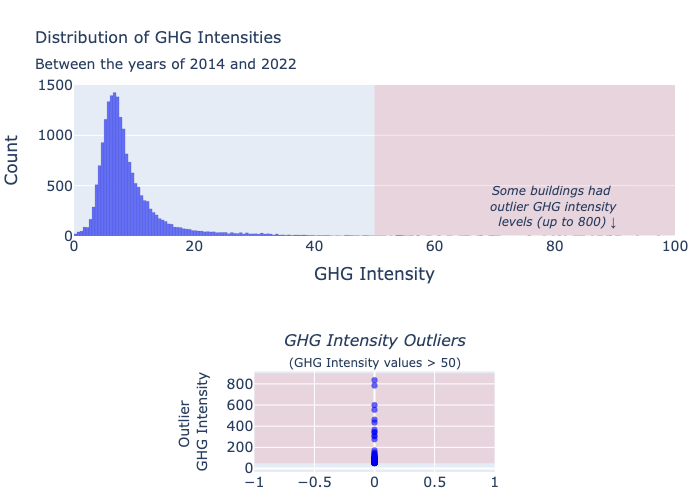

In [605]:
fig = create_ghg_intensity_distribution_plot(df, version='mobile')
fig

for dir in dirs:
    fig.write_html( os.path.join(dir,'distribution_of_GHG_intensity_mobile.html'), include_plotlyjs="cdn" )

out, reduce_memory = show_fig(fig, reduce_memory)
if reduce_memory==True:
    with open(os.path.join(static_blog_pth,'distribution_of_GHG_intensity_mobile.png'), "wb") as f:
        f.write(out)
Image(out)


## Compliance type counts over time

Count the number of reporting / non-reporting for every year, highlighting the impact of COVID

In [606]:
# Count each new column per year
value_counts = df.groupby('DataYear')['Reported'].value_counts()
non_reporting_counts = value_counts.xs(0, level='Reported')
reporting_counts = value_counts.xs(1, level='Reported')

# Create the figure
fig = go.Figure()

# Add traces for each category
fig.add_trace(go.Scatter(x=reporting_counts.index, y=reporting_counts.values,
                         mode='lines+markers', name='Reported',
                         line=dict(width=4, color='rgba(0, 0,255, 0.7)'),
                         marker=dict(symbol='circle', size=10)))

fig.add_trace(go.Scatter(x=non_reporting_counts.index, y=non_reporting_counts.values,
                         mode='lines+markers', name="Didn't Report",
                         line=dict(width=4, color='rgba(255, 0, 0, 0.7)'),
                         marker=dict(symbol='circle', size=10)))

fig.add_trace( go.Scatter( x=[2018.5, 2019.5, 2019.5, 2018.5, 2018.5], 
                          y=[0, 0, np.max(reporting_counts)*1.2, np.max(reporting_counts)*1.2, 0 ], 
                         fill='toself', mode='lines', name='Covid Data Disruption' )
)

# Update layout
fig.update_layout(title="Count of Buildings That Did/Didn't Report Emissions by Year",
                  xaxis_title='Year of Emissions<br>(One year before data is reported)',
                  yaxis_title='Count of Buildings',
                  legend_title='Category')

# Show the plot
#pio.show(fig)
iplot(fig)


for dir in dirs:
    fig.write_html( os.path.join(dir,'reporting_counts_over_time.html'), include_plotlyjs="cdn" )

# Save jpg version for mobile
out, reduce_memory = show_fig(fig, reduce_memory)
with open(os.path.join(static_blog_pth,'reporting_counts_over_time.png'), "wb") as f:
    f.write(out)


## Analysis: Covid saw temporary drop in building reporting
Buildings report the prior years emissions data the following spring. Thus, 2019's data was supposed to be reported in Spring 2020 but it seems like Covid disrupted this. As a result, many observations of non-reporting are because of Covid. 

For robustness, we will create a subset of the dataframe without the covid data later in this code

## Analysis: Correlation of "GHG Intensity Last Year" and "Compliance This Year"

### First: calculate "GHG Intensity last year" and "Chang in GHG Intensity Last Year"

- GHG Intensity Last Year is just the GHG intensity the year prior
    - i.e. if the Data Year is 2019, then 'GHG Intensity Last Year' would be equal to GHG Intensity in 2018

- Change in GHG Intensity Last Year is equal to the difference between the GHG intensity from two years ago to one year ago
    - i.e. if the Data Year is 2019, Change in GHG Intensity Last year is equal to the GHG intensity from 2018 minus the GHG Intensity from 2017

In [607]:
# Create the new column 'GHGIntensity_last_year'
df['GHGIntensity_LastYear'] = df.apply(
    lambda row: df.loc[
        (df['DataYear'] == row['DataYear'] - 1) & 
        (df['Reported'] == 1) & 
        (df['ID'] == row['ID']),  # Match by id
        'GHGIntensity'
    ].iloc[0] if len(df.loc[
        (df['DataYear'] == row['DataYear'] - 1) & 
        (df['Reported'] == 1) & 
        (df['ID'] == row['ID']),  # Match by id
        'GHGIntensity'
    ]) > 0 else None,
    axis=1
)

# Create the new column 'pct_chng_GHGIntensity_last_year'
df['Chng_GHGIntensity_LastYear'] = df.apply(
    lambda row: (
        (
            df.loc[
                (df['DataYear'] == row['DataYear'] - 1) & 
                (df['Reported'] == 1) & 
                (df['ID'] == row['ID']),  # Match by id
                'GHGIntensity'
            ].iloc[0]

              -

            df.loc[
                (df['DataYear'] == row['DataYear'] - 2) & 
                (df['Reported'] == 1) & 
                (df['ID'] == row['ID']),  # Match by id
                'GHGIntensity'
            ].iloc[0]
        ) 
        
    ) if len(df.loc[
        (df['DataYear'] == row['DataYear'] - 1) & 
        (df['Reported'] == 1) & 
        (df['ID'] == row['ID']),  # Match by id
        'GHGIntensity'
    ]) == 1 and len(df.loc[
        (df['DataYear'] == row['DataYear'] - 2) & 
        (df['Reported'] == 1) & 
        (df['ID'] == row['ID']),  # Match by id
        'GHGIntensity'
    ]) == 1 else None,
    axis=1
)




### Demonstrate newly calculated values

In [608]:
df.sort_values( ['ID', 'DataYear']).head()[['DataYear', 'ID','GHGIntensity', 'GHGIntensity_LastYear', 'Chng_GHGIntensity_LastYear']]

DataYear      ID  GHGIntensity  GHGIntensity_LastYear  \
8645       2014  100001          21.2                    NaN   
8623       2015  100001          20.7                   21.2   
10018      2016  100001          19.2                   20.7   
13408      2017  100001          18.8                   19.2   
14232      2018  100001          17.4                   18.8   

       Chng_GHGIntensity_LastYear  
8645                          NaN  
8623                          NaN  
10018                        -0.5  
13408                        -1.5  
14232                        -0.4

## Do different building types have different reporting compliance rates?

In [673]:
def plot_mean_and_count(df, 
                        category_col='PrimaryPropertyType', 
                        binary_col='non_reporting', min_count = 0):
    """
    Plots a bar chart showing:
      1) The mean of the binary column (non_reporting) by category on the primary y-axis.
      2) The count of rows in each category on the secondary y-axis.
    
    The categories are ordered by descending mean.
    """


    # Group by category column and compute mean & count
    agg_df = (df.groupby(category_col)[binary_col]
              .agg(['mean', 'count'])
              .reset_index()
              .sort_values(by='mean', ascending=False))
    
    agg_df['mean'] = np.round(agg_df['mean'], 3)

    agg_df = agg_df[ agg_df['count'] >=min_count]
    
   # Determine legend position and figure width based on number of categories
    #legend_position = 'top' if len(agg_df) > 20 else 'right'
    #figure_width = 2000 if len(agg_df) > 20 else 1100
    legend_position = 'top'

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # First trace: mean of non_reporting (Primary Y-Axis)
    fig.add_trace(
        go.Bar(
            x=agg_df[category_col],
            y=agg_df['mean'],
            name='Non-Reporting Rate',
            marker=dict(color='blue'),
        ),
        secondary_y=False
    )

    # Second trace: count of buildings (Secondary Y-Axis)
    fig.add_trace(
        go.Scatter(
            x=agg_df[category_col],
            y=agg_df['count'],
            name=f'Count of Buildings <br>(Minimum {min_count})' if min_count > 0 else 'Count of Buildings',
            marker=dict(color='orange'),
            mode='lines+markers'
        ),
        secondary_y=True
    )

    # Layout update
    fig.update_layout(
        title='Non-Reporting Rates<br>and Observation Count by Building Category',
        xaxis_title='Building Type',
        xaxis=dict(categoryorder='array', categoryarray=agg_df[category_col]),
        xaxis_tickangle=-45,
        legend=dict(
            orientation='v',
            font=dict(size=10),  
            x=0.8,  
            y=1.15,  
            xanchor='center',  
            yanchor='bottom'  
        ),
        autosize=True,
        margin=dict(l=30, r=30, t=150, b=30)
    )

    # Update Y-axes properly
    fig.update_yaxes(
        title_text="Non-Reporting Rate",
        title_font=dict(color="rgba(0, 0, 255, 1)"),  # Blue
        tickformat=".0%",
        range=[0, max(.55, agg_df['mean'].max())],
        secondary_y=False
    )

    fig.update_yaxes(
        title_text="Count of Buildings",
        title_font=dict(color="rgba(255, 165, 0, 1)"),  # Orange
        secondary_y=True,
        overlaying="y",  # Ensure the second y-axis overlays correctly
        side="right"
    )



    return fig

### Looking at building categories with at least 100 observations:

In [674]:
# Define the binary target column and transform floor area into millions
df['GrossFloorArea_Mil'] = df['GrossFloorArea']/1000000
df['non_reporting'] = (df['Reported']==0).astype(int)

In [675]:
min_count = 100
fig = plot_mean_and_count(df, 
                    category_col='PrimaryPropertyType', 
                    binary_col='non_reporting',
                    min_count=min_count)


for dir in dirs:
    fig.write_html( os.path.join(dir,f'reporting_rates_by_building_type_min_{min_count}.html'), include_plotlyjs="cdn" )

fig

In [676]:
out, reduce_memory = show_fig(fig, reduce_memory)
if reduce_memory:
    with open(os.path.join(static_blog_pth,f'reporting_rates_by_building_type_min_{min_count}.png'), "wb") as f:
        f.write(out)

## Looking at all building category types:

In [677]:
fig = plot_mean_and_count(df, 
                    category_col='PrimaryPropertyType', 
                    binary_col='non_reporting',
                    min_count=0)


for dir in dirs:
    fig.write_html( os.path.join(dir,f'reporting_rates_by_building_type_min_all.html'), include_plotlyjs="cdn" )

fig

In [614]:
out, reduce_memory = show_fig(fig, reduce_memory)
if reduce_memory:
    with open(os.path.join(static_blog_pth,f'reporting_rates_by_building_type_min_all.png'), "wb") as f:
        f.write(out)

##  Regression Model to Determine Effects of GHG Intensity on Reporting

Linear probability model with various controls

In [615]:
def linear_prob_model(df, regressors, target, dummy_vars=None):

    # Start with a copy of the DataFrame
    df_cleaned = df.copy()

    if dummy_vars:
        for var in dummy_vars:
            if var in df_cleaned.columns:
                dummies = pd.get_dummies(df_cleaned[var], prefix=var, drop_first=True, dtype=int)
                df_cleaned = df_cleaned.join(dummies)
                regressors.extend(dummies.columns)  # Add new dummy variable names to regressors list
            else:
                print(f"Warning: '{var}' not found in DataFrame.")

    # Initialize a dictionary to track dropped rows for each regressor
    dropped_rows = {}
    nrow_init = df_cleaned.shape[0]

    # Drop rows with missing values for each regressor and track counts
    for regressor in regressors:
        initial_rows = len(df_cleaned)
        df_cleaned = df_cleaned.dropna(subset=[regressor])
        dropped_rows[regressor] = initial_rows - len(df_cleaned)

    # Report the number of dropped rows for each regressor
    for regressor, count in dropped_rows.items():
        if count>0:
            print(f"Rows dropped due to missing values in '{regressor}': {count} ({round(100*(count/nrow_init), 1)}%)")
    total_dropped = np.sum( n_dropped for n_dropped in dropped_rows.values() )

    # Set up the linear probability model
    X = df_cleaned[regressors]
    X = sm.add_constant(X)  # Add a constant for the intercept
    y = df_cleaned[target]

    # Fit the regression model
    model = sm.OLS(y, X).fit()

    # Display the summary of the model
    print(model.summary())

    out = {'nrows_init':nrow_init,
        'total_dropped_rows': total_dropped,
           'y_obs_that_are_1': int(y.sum()),
            'y_obs_that_are_0': int(len(y) - y.sum())
              }
    
    return model, out

In [616]:
target_var = 'non_reporting'
regressors = [
    'GHGIntensity_LastYear',
    'Chng_GHGIntensity_LastYear',
    'GrossFloorArea_Mil',
    'YearBuilt'
]

dummy_vars = ['PrimaryPropertyType', 'DataYear'
             # , 'ID'
            ]

# Map pretty names for each variable
pretty_names = {
    'const' : 'Constant',
    'non_reporting': "Didn't Report",
    'GHGIntensity_LastYear': 'GHG Intensity (Last Year)',
    'Chng_GHGIntensity_LastYear': 'Change in GHG Intensity (Last Two Years)',
    'GrossFloorArea_Mil': 'Gross Floor Area (Millions)',
    'YearBuilt' : 'Year Building Was Built'
}


## Basic Regression

In [617]:
model,out = linear_prob_model(df, regressors, target_var, dummy_vars=dummy_vars)

# Extract regression results
results = {
    "dependent_variable": pretty_names[target_var],  # Pretty name for dependent variable
    "number_of_observations": int(model.nobs),  # Number of observations
    "r_squared": model.rsquared,  # R-squared
    "adj_r_squared": model.rsquared_adj,  # Adjusted R-squared
    "coefficients": {  # Coefficients with pretty names
        pretty_names.get(name, name): coef for name, coef in model.params.items()
    },
    "p_values": {  # P-values with pretty names
        pretty_names.get(name, name): pval for name, pval in model.pvalues.items()
    },
    "confidence_intervals": {  # 95% confidence intervals with pretty names
        pretty_names.get(name, name): list(ci) for name, ci in model.conf_int().iterrows()
    },
    "covariance_type": model.cov_type,  # Covariance type
    "building_type_dummy": "Included",  # Covariance type
    "year_fixed_effects": "Included",  # Covariance type
}


# Delete the fixed effects coefficients: 
results['coefficients'] = {k:v for k, v in results['coefficients'].items() if 'PrimaryPropertyType' not in k}
results['p_values'] = {k:v for k, v in results['p_values'].items() if 'PrimaryPropertyType' not in k}
results['coefficients'] = {k:v for k, v in results['coefficients'].items() if 'DataYear' not in k}
results['p_values'] = {k:v for k, v in results['p_values'].items() if 'DataYear' not in k}

# add in the information about y balance and deleted observations
results['total_dropped_rows_pct'] =  round(100*out['total_dropped_rows'] / out['nrows_init'], 2)
results['total_dropped_rows'] = out['total_dropped_rows']
results['pct_obs_are_one'] = round( 100*out['y_obs_that_are_1']/(out['y_obs_that_are_1']+out['y_obs_that_are_0']), 2)
results['pct_obs_are_zero'] = round( 100*out['y_obs_that_are_0']/(out['y_obs_that_are_1']+out['y_obs_that_are_0']), 2)



# Save as JSON
for dir in dirs:
    fpath = os.path.join(dir,'regression_results_w_covid.json')
    with open(fpath, "w") as f:
        json.dump(results, f, indent=4)

Rows dropped due to missing values in 'GHGIntensity_LastYear': 8544 (34.3%)
Rows dropped due to missing values in 'Chng_GHGIntensity_LastYear': 5007 (20.1%)
Rows dropped due to missing values in 'GrossFloorArea_Mil': 752 (3.0%)
                            OLS Regression Results                            
Dep. Variable:          non_reporting   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     46.28
Date:                Mon, 17 Feb 2025   Prob (F-statistic):               0.00
Time:                        22:31:39   Log-Likelihood:                -1966.3
No. Observations:               10588   AIC:                             4055.
Df Residuals:                   10527   BIC:                             4498.
Df Model:                          60                                         
Covariance Type:            nonrobust                        

/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_85841/7154987.py:29: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.



## Analysis of Regression Results: No Effect Found
Using different regression combinations of 
- GHG Intensity Last Year
- Change in GHG Intensity from 2 years ago to 1 year ago
- Square footage of building

there generally is no effect of GHG Intensity last year or change in GHG intensity from two years ago to 1 year ago. 

Interestingly but unrelatedly, it seems that larger buildings are more likely to be compliant in their reporting. The effect size is small though

## Graph to Show Averages

Show the mean and median value of GHG Intensity (or Change in GHG Intensity Last Year) by compliance status

In [618]:


def create_scatter_with_means(df, x, y, hover_data, value_mapping, base_fontsize=12, x_label=None, y_label=None, title=None):
    """
    Create a series of side-by-side subplot scatter plots (one per unique x category),
    each with a horizontal mean line. The subplots are arranged horizontally with minimal gap.
    
    Parameters:
    - df: DataFrame containing the data.
    - x: Column name for the x-axis category variable.
    - y: Column name for the continuous y-axis variable.
    - hover_data: List of columns to display on hover.
    - value_mapping: Dictionary to map the values of the x column (often binary) to meaningful labels.
    - base_fontsize: Base font size for scaling other font sizes.
    - x_label: Label for the x-axis (overall).
    - y_label: Label for the y-axis (overall).
    - title: Main title of the entire figure.
    """
    
    # Copy and prepare the dataframe
    df = df.copy()
    df[x] = df[x].map(value_mapping)
    
    # Identify unique categories in the x variable
    categories = df[x].unique()
    categories = [cat for cat in categories if pd.notnull(cat)]  # Ensure no NaN
    
    # Calculate mean and median per category
    mean_values = df.groupby(x)[y].mean()
    median_values = df.groupby(x)[y].median()
    
    # Create subplots: one row, as many columns as unique categories
    fig = make_subplots(
        rows=1, cols=2,
        horizontal_spacing=0.1,  # Narrow gap between subplots
        shared_yaxes=True,        # Share the same y-axis
        subplot_titles=categories
    )

    colors = ['rgba(0, 0, 255, 1)', 'rgba(255, 0, 0, 1)']  
    colors_t = ['rgba(0, 0, 255, 0.5)', 'rgba(255, 0, 0, 0.5)']  # Transparent versions of 'blue' and 'red'
    
    # For each category, add a scatter trace
    for i, category in enumerate(categories, start=1):

        cat_data = df[df[x] == category]
        
        # Add a small horizontal jitter around x=1 for the scatter
        jitter = np.random.uniform(0.999, 1.001, size=len(cat_data))
        
        # Create the scatter trace
        fig.add_trace(
            go.Scatter(
                x=jitter,
                y=cat_data[y],
                mode='markers',
                marker=dict(size=8, opacity=0.8, color=colors_t[i-1]),
                hovertemplate='<br>'.join([f"{col}: %{{customdata[{idx}]}}" 
                                           for idx, col in enumerate(hover_data)]) if hover_data else None,
                customdata=cat_data[hover_data] if hover_data else None,
                name = f'{y_label} <br>for "{category}"'
            ),
            row=1, col=i
        )
        
        # Add mean line
        mean_val = mean_values.loc[category]
        fig.add_hline(
            y=mean_val,
            line_dash="dash",
            line_color=colors[i-1],
            row=1, col=i,
            name = f'Mean {y_label}',
            line_width=3
        )
        
        # Add annotation for mean and median
        median_val = median_values.loc[category]
        fig.add_annotation(
            x=1.001,  # slightly to the right of the main cluster
            y=mean_val+20,
            text=f"Mean: {mean_val:.2f}<br>Median: {median_val:.2f}",
            showarrow=False,
            xanchor='left',
            yanchor='bottom',
            font=dict(size=base_fontsize * 1.2, color=colors[i-1]),
            row=1, col=i
        )
        
        # Update x-axis for this subplot (just show a single vertical line)
        fig.update_xaxes(
            showline=True,
            linecolor='black',
            zeroline=True,
            showticklabels=False,
            showgrid=False,
            range=[0.99, 1.01],   # tight range around jitter
            tickfont=dict(size=base_fontsize * 1.2),
            row=1, col=i
        )

    # Update the y-axis (shared) styling
    fig.update_yaxes(
        showline=True, 
        linecolor='black',
        showgrid=False,
        title_text=y_label, 
        title_font=dict(size=base_fontsize * 1.1),
        tickfont=dict(size=base_fontsize * 1.2),
        row=1, col=1
    )
    
    # Update the layout
    fig.update_layout(
        autosize=True,
        title=dict(
            text=f'{title or f"Scatterplot of {y} by {x}"}',
            x=0.5,
            font=dict(size=base_fontsize * 1.3)
        ),
        plot_bgcolor='white',
        margin=dict(l=30, r=30, t=150, b=30),
        legend=dict(
                font=dict(size=base_fontsize * 0.7),
                x=0.95,   # Move legend closer to the plot (1 is far right)
                y=1,      # Move legend up
                #xanchor='right',  
                #yanchor='top',
                #traceorder='normal'  # Keep legend items in normal order
            )
    )

    return fig

## Comparing Change in GHG Intensity

In [619]:
base_fontsize = 12

title = (f'<span style="font-size:{base_fontsize * 1.3}px;">' +
         'Do changes in emission intensities predict reporting compliance for Chicago buildings?</span>'
         f'<br><span style="font-size:{base_fontsize * 1.1};">Comparing the <b>change In GHG Intensity</b> In <i>last 2 years</i>'+
          ' with the <b>reporting compliance</b> <i>this year</i></span>'
        )

value_mapping = {1: "Didn't Report", 0: "Reported"}
fig = create_scatter_with_means(
    df=df.dropna(subset=['Chng_GHGIntensity_LastYear']),
    x='non_reporting',
    y='Chng_GHGIntensity_LastYear',
    #hover_data=['PropertyName', 'DataYear', 'non_reporting', 'GHGIntensity_LastYear', 'Chng_GHGIntensity_LastYear', 'GrossFloorArea_Mil'],
    hover_data=['PropertyName', 'DataYear'], # Reduced columns to make file size smaller
    value_mapping=value_mapping,
    base_fontsize=12,
    x_label='Reported This Year?',
    y_label='Change In GHG Intensity',
    title=title
)



iplot(fig)
for dir in dirs:
    fig.write_html( os.path.join(dir,'change_GHG_trend_by_compliance.html'), include_plotlyjs="cdn" )


### Same graph, but look at GHG Intensity instead of Change in GHG Intensity

In [620]:

title = (f'<span style="font-size:{base_fontsize * 1.3}px;">' +
         'Does emission intensities predict reporting compliance for Chicago buildings?</span>'
         f'<br><span style="font-size:{base_fontsize * 1.1};">'+
         'Comparing the <b>GHG Intensity</b> In <i>last year</i>'+
         ' with the <b>reporting compliance</b> <i>this year</i></span>'
        )

value_mapping = {1: "Didn't Report", 0: "Reported"}
fig = create_scatter_with_means(
    df=df.dropna(subset=['GHGIntensity_LastYear']),
    x='non_reporting',
    y='GHGIntensity_LastYear',
    #hover_data=['PropertyName', 'DataYear', 'non_reporting', 'GHGIntensity_LastYear', 'Chng_GHGIntensity_LastYear', 'GrossFloorArea_Mil'],
    hover_data=['PropertyName', 'DataYear'], # Reduced columns to make file size smaller
    value_mapping=value_mapping,
    base_fontsize=12,
    x_label='Reported This Year?',
    y_label='GHG Intensity',
    title=title
)


iplot(fig)
for dir in dirs:
    fig.write_html( os.path.join(dir,'GHG_last_year_by_compliance.html'), include_plotlyjs="cdn" )


## For blog: Show the same graph, but only include the most recent year of data

In [621]:
most_recent_year = int(df['DataYear'].max()) +1 # datayear is when emissions happened, reporting happens 1 year after (in march)
year_prior = most_recent_year - 1
two_years_prior = most_recent_year -2

df_subset_recent = df[df['DataYear'] == year_prior]

print(f"""Most recent data year is {most_recent_year}. 
Analyzing compliance in year {most_recent_year} based off reporting in year {year_prior}
Analyzing compliance in year {most_recent_year} based off change in emissions from {two_years_prior} to {year_prior}
"""
)

df_subset_recent.head()

Most recent data year is 2023. 
Analyzing compliance in year 2023 based off reporting in year 2022
Analyzing compliance in year 2023 based off change in emissions from 2021 to 2022



ID  DataYear ReportingStatus  GrossFloorArea  TotalGHGEmissions  \
17753  175891      2022  Submitted Data        172500.0              452.4   
17754  256646      2022   Not Submitted        184905.0                NaN   
17755  251245      2022  Submitted Data        249095.0             1434.0   
17756  121374      2022   Not Submitted         55129.0                NaN   
17757  161872      2022          Exempt         75104.0                NaN   

       GHGIntensity  NumberOfBuildings  ChicagoEnergyRating  ENERGYSTARScore  \
17753           3.0                1.0                  4.0            100.0   
17754           NaN                NaN                  0.0              NaN   
17755           5.8                2.0                  3.5             74.0   
17756           NaN                NaN                  0.0              NaN   
17757           NaN                NaN                  NaN              NaN   

       ElectricityUse  NaturalGasUse  DistrictSteamUse  \
17753       2069532.4      3384519.4               0.0   
17754             NaN            NaN               NaN   
17755       3345590.2     18702028.9               0.0   
17756             NaN            NaN               NaN   
17757             NaN            NaN               NaN   

       DistrictChilledWaterUse  AllOtherFuelUse  SiteEUI  SourceEUI  \
17753                      0.0              NaN     36.4       62.3   
17754                      NaN              NaN      NaN        NaN   
17755                      0.0              NaN     88.5      116.4   
17756                      NaN              NaN      NaN        NaN   
17757                      NaN              NaN      NaN        NaN   

       WeatherNormalizedSiteEUI  WeatherNormalizedSourceEUI  Reported  \
17753                      36.4                        62.3         1   
17754                       NaN                         NaN         0   
17755                      94.1                       121.1         1   
17756                       NaN                         NaN         0   
17757                       NaN                         NaN         0   

                           PropertyName        PrimaryPropertyType  YearBuilt  \
17753       [Building Name Unavailable]        Multifamily Housing     1962.0   
17754       [Building Name Unavailable]                        NaN        NaN   
17755          3800 N. Lake Shore Drive        Multifamily Housing     1927.0   
17756                 53100522--CHICAGO  Supermarket/Grocery Store     2013.0   
17757  Parkside Elementary Academy -CPS                K-12 School     1917.0   

       GHGIntensity_LastYear  Chng_GHGIntensity_LastYear  GrossFloorArea_Mil  \
17753                    3.5                         1.1            0.172500   
17754                    NaN                         NaN            0.184905   
17755                    NaN                         NaN            0.249095   
17756                   27.8                        -4.9            0.055129   
17757                    NaN                         NaN            0.075104   

       non_reporting  
17753              0  
17754              1  
17755              0  
17756              1  
17757              1

In [622]:
title = (f'<span style="font-size:{base_fontsize * 1.3}px;">' +
         'Do changes in <b>emission intensities</b> predict <b>reporting compliance</b>?</span>'
         f'<br><span style="font-size:{base_fontsize * 1.1};">'+
         f'<b>Change In GHG Intensity</b> from <i>{two_years_prior} to {year_prior}</i>'+
          f' against <b>reporting compliance</b> in <i>{most_recent_year}</i> for large Chicago buildings</span>'
        )

value_mapping = {1: f"Didn't Report in {most_recent_year}", 0: f"Reported in {most_recent_year}"}
fig = create_scatter_with_means(
    df=df_subset_recent.dropna(subset=['Chng_GHGIntensity_LastYear']),
    x='non_reporting',
    y='Chng_GHGIntensity_LastYear',
    hover_data=['PropertyName'], # Reduced columns to make file size smaller
    value_mapping=value_mapping,
    base_fontsize=12,
    x_label=f'Reported Data in {most_recent_year}?',
    y_label=f'Change In GHG Intensity<br>from {two_years_prior} to {year_prior}',
    title=title
)


iplot(fig)
for dir in dirs:
    fig.write_html( os.path.join(dir,'change_GHG_trend_by_compliance_recent_data_only.html'), include_plotlyjs="cdn" )

# Save jpg version for mobile
out, reduce_memory = show_fig(fig, reduce_memory)
with open(os.path.join(static_blog_pth,'change_GHG_trend_by_compliance_recent_data_only.png'), "wb") as f:
    f.write(out)


In [623]:
title = (f'<span style="font-size:{base_fontsize * 1.3}px;">' +
         'Do <b>emission intensities</b> predict <b>reporting compliance</b>?</span>'
         f'<br><span style="font-size:{base_fontsize * 1.1};">'+
         f'<b>GHG Intensity</b> in <i>{year_prior}</i>'+
         f' against <b>reporting compliance</b> in <i>{most_recent_year}</i> for large Chicago buildings</i></span>'
        )

value_mapping = {1: f"Didn't Report in {most_recent_year}", 0: f"Reported in {most_recent_year}"}
fig = create_scatter_with_means(
    df=df_subset_recent.dropna(subset=['Chng_GHGIntensity_LastYear']),
    x='non_reporting',
    y='GHGIntensity_LastYear',
    hover_data=['PropertyName'], # Reduced columns to make file size smaller
    value_mapping=value_mapping,
    base_fontsize=12,
    x_label=f'Reported Data in {most_recent_year}?',
    y_label=f'GHG Intensity in {year_prior}',
    title=title
)


iplot(fig)
for dir in dirs:
    fig.write_html( os.path.join(dir,'GHG_last_year_by_compliance_recent_data_only.html'), include_plotlyjs="cdn" )

out, reduce_memory = show_fig(fig, reduce_memory)
with open(os.path.join(static_blog_pth,'GHG_last_year_by_compliance_recent_data_only.png'), "wb") as f:
    f.write(out)



---

## Robustness: Dropping Covid

Do the results change at all if we drop year=2019? (the year of the covid data anomaly)


In [624]:
df_no_covid = df.copy()
df_no_covid = df_no_covid[df_no_covid['DataYear']!=2019]

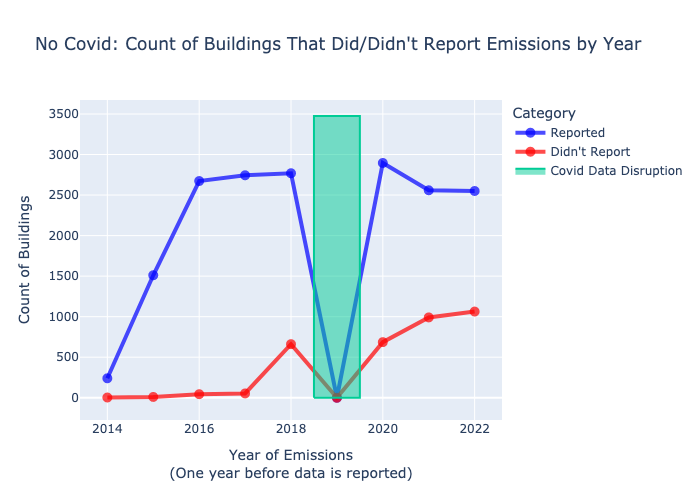

In [625]:
# Count each new column per year
value_counts = df_no_covid.groupby('DataYear')['Reported'].value_counts()
non_reporting_counts = value_counts.xs(0, level='Reported')
reporting_counts = value_counts.xs(1, level='Reported')

non_reporting_counts[2019] = 0
reporting_counts[2019] = 0

non_reporting_counts.index = non_reporting_counts.index.astype(int)
reporting_counts.index = reporting_counts.index.astype(int)

non_reporting_counts = non_reporting_counts.sort_index()
reporting_counts = reporting_counts.sort_index()

# Create the figure
fig = go.Figure()

# Add traces for each category
fig.add_trace(go.Scatter(x=reporting_counts.index, y=reporting_counts.values,
                         mode='lines+markers', name='Reported',
                         line=dict(width=4, color='rgba(0, 0,255, 0.7)'),
                         marker=dict(symbol='circle', size=10)))

fig.add_trace(go.Scatter(x=non_reporting_counts.index, y=non_reporting_counts.values,
                         mode='lines+markers', name="Didn't Report",
                         line=dict(width=4, color='rgba(255, 0, 0, 0.7)'),
                         marker=dict(symbol='circle', size=10)))

fig.add_trace( go.Scatter( x=[2018.5, 2019.5, 2019.5, 2018.5, 2018.5], 
                          y=[0, 0, np.max(reporting_counts)*1.2, np.max(reporting_counts)*1.2, 0 ], 
                         fill='toself', mode='lines', name='Covid Data Disruption' )
)

# Update layout
fig.update_layout(title="No Covid: Count of Buildings That Did/Didn't Report Emissions by Year",
                  xaxis_title='Year of Emissions<br>(One year before data is reported)',
                  yaxis_title='Count of Buildings',
                  legend_title='Category')



out, reduce_memory = show_fig(fig, reduce_memory)

if reduce_memory:
    with open(os.path.join(fig_dir,'reporting_counts_over_time_NO_COVID.png'), "wb") as f:
        f.write(out)
    out = Image(out)
out


Results: It still seems like the isn't really a relationship, although GHG intensity seems to be associated with a tiny increase in non-reporting. The magnitude is very small and the likelihood this is from chance is high. 

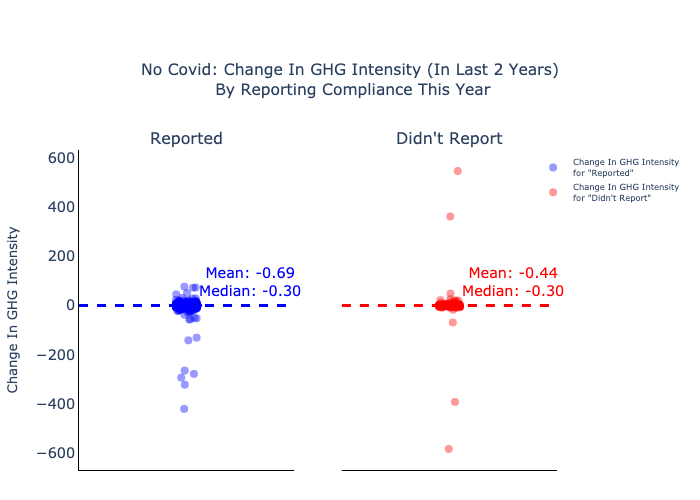

In [626]:
value_mapping = {1: "Didn't Report", 0: "Reported"}
fig = create_scatter_with_means(
    df=df_no_covid,
    x='non_reporting',
    y='Chng_GHGIntensity_LastYear',
    hover_data=['PropertyName', 'DataYear', 'non_reporting', 'GHGIntensity_LastYear', 'Chng_GHGIntensity_LastYear', 'GrossFloorArea_Mil'],
    value_mapping=value_mapping,
    base_fontsize=12,
    x_label='Reported This Year?',
    y_label='Change In GHG Intensity',
    title='No Covid: Change In GHG Intensity (In Last 2 Years)<br> By Reporting Compliance This Year'
)


out, reduce_memory = show_fig(fig, reduce_memory)


if reduce_memory:
    with open(os.path.join(fig_dir,'change_GHG_trend_by_compliance_NO_COVID.png'), "wb") as f:
        f.write(out)
    out = Image(out)
out

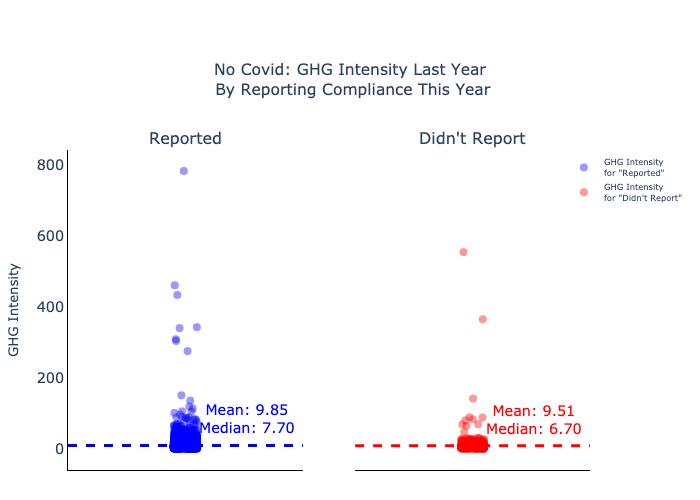

In [627]:


value_mapping = {1: "Didn't Report", 0: "Reported"}
fig = create_scatter_with_means(
    df=df_no_covid,
    x='non_reporting',
    y='GHGIntensity_LastYear',
    hover_data=['PropertyName', 'DataYear', 'non_reporting', 'GHGIntensity_LastYear', 'Chng_GHGIntensity_LastYear', 'GrossFloorArea_Mil'],
    value_mapping=value_mapping,
    base_fontsize=12,
    x_label='Reported This Year?',
    y_label='GHG Intensity',
    title='No Covid: GHG Intensity Last Year<br> By Reporting Compliance This Year'
)

out, reduce_memory = show_fig(fig, reduce_memory)
out 

if reduce_memory:
    with open(os.path.join(fig_dir,'GHG_last_year_by_compliance_NO_COVID.png'), "wb") as f:
        f.write(out)
    out = Image(out)
out

## Drop outliers 

In [628]:
n_obs_original = df.shape[0]

# Identify buildings with any row having GHGIntensity > 100
buildings_with_outliers = df.loc[df['GHGIntensity'] > 100, 'ID'].unique()

# Drop all rows for those buildings
df_no_outliers = df[~df['ID'].isin(buildings_with_outliers)]

print(f"Dropped {n_obs_original - len(df_no_outliers)} observations out of {n_obs_original} ({round(100*(n_obs_original - len(df_no_outliers))/n_obs_original, 2)}%) by dropping all rows for buildings with any GHGIntensity over 100")

Dropped 103 observations out of 24891 (0.41%) by dropping all rows for buildings with any GHGIntensity over 100


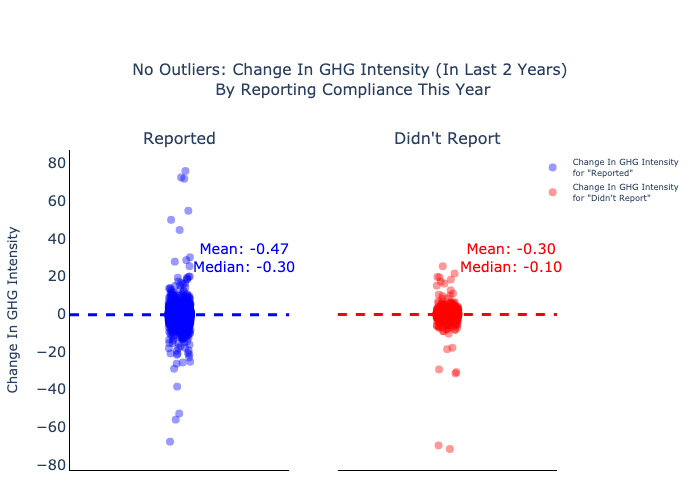

In [629]:
value_mapping = {1: "Didn't Report", 0: "Reported"}
fig = create_scatter_with_means(
    df=df_no_outliers,
    x='non_reporting',
    y='Chng_GHGIntensity_LastYear',
    hover_data=['PropertyName', 'DataYear', 'non_reporting', 'GHGIntensity_LastYear', 'Chng_GHGIntensity_LastYear', 'GrossFloorArea_Mil'],
    value_mapping=value_mapping,
    base_fontsize=12,
    x_label='Reported This Year?',
    y_label='Change In GHG Intensity',
    title='No Outliers: Change In GHG Intensity (In Last 2 Years)<br> By Reporting Compliance This Year'
)

out, reduce_memory = show_fig(fig, reduce_memory)
out 

if reduce_memory:
    with open(os.path.join(fig_dir,'change_GHG_trend_by_compliance_NO_OUTLIERS.png'), "wb") as f:
        f.write(out)
    out = Image(out)
out
    


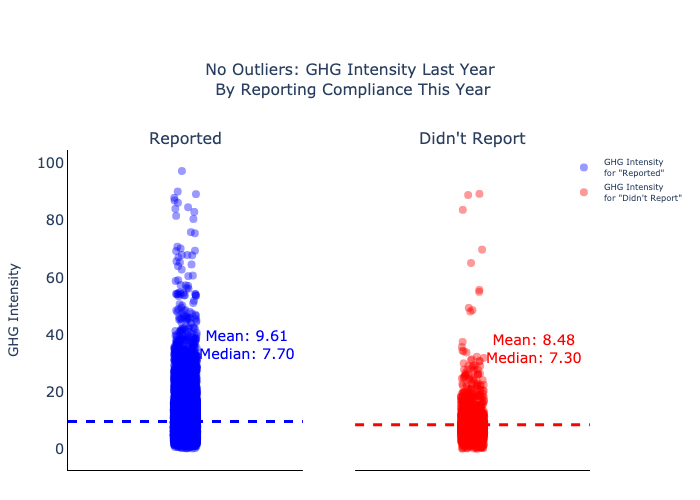

In [630]:
# Example usage:

value_mapping = {1: "Didn't Report", 0: "Reported"}
fig = create_scatter_with_means(
    df=df_no_outliers,
    x='non_reporting',
    y='GHGIntensity_LastYear',
    hover_data=['PropertyName', 'DataYear', 'non_reporting', 'GHGIntensity_LastYear', 'Chng_GHGIntensity_LastYear', 'GrossFloorArea_Mil'],
    value_mapping=value_mapping,
    base_fontsize=12,
    x_label='Reported This Year?',
    y_label='GHG Intensity',
    title='No Outliers: GHG Intensity Last Year<br> By Reporting Compliance This Year'
)

out, reduce_memory = show_fig(fig, reduce_memory)
out 

    
if reduce_memory:
    with open(os.path.join(fig_dir,'GHG_last_year_by_compliance_NO_OUTLIERS.png'), "wb") as f:
        f.write(out)
    out = Image(out)
out

## Results: Dropping outliers

Again, no significant result. The only thing we see from dropping the outliers is that now it seems that having a higher GHG intensity 
seems to be associated WITH reporting, which is the opposite of our hypothesis (reporting buildings have higher mean and median GHG intenstity). Again,
the magnitude is very small so we can likely ignore this. 

## Some extra graphs comparing the two variables: Change in GHG Intensity and GHG Intensity last year

In [631]:


def customizable_scatterplot(df, x_var, y_var, color_var, x_limits=None, y_limits=None, title=None):
    """
    Create a customizable scatterplot.

    Parameters:
    - df: DataFrame containing the data.
    - x_var: Column name for the x-axis.
    - y_var: Column name for the y-axis.
    - color_var: Column name for the binary variable to set discrete coloring.
    - x_limits: Tuple (min, max) to set x-axis limits.
    - y_limits: Tuple (min, max) to set y-axis limits.
    - title: Title of the plot (default: None).
    """
    # Ensure the color_var is treated as a categorical variable for discrete coloring
    df[color_var] = df[color_var].astype(str)

    # Create scatterplot
    fig = px.scatter(
        df,
        x=x_var,
        y=y_var,
        color=color_var,
        color_discrete_sequence=["blue", "orange"],  # Discrete colors for binary 0 and 1
        opacity=0.2,  # Add transparency here
        labels={x_var: x_var, y_var: y_var, color_var: color_var},
        title=title or f'Scatterplot of {y_var} vs {x_var}'
    )
    
    # Set axis limits if provided
    if x_limits:
        fig.update_xaxes(range=x_limits)
    if y_limits:
        fig.update_yaxes(range=y_limits)
    
    # Update layout for better aesthetics
    fig.update_layout(
        height=600,
        width=800,
        legend_title=color_var
    )
    

    return fig

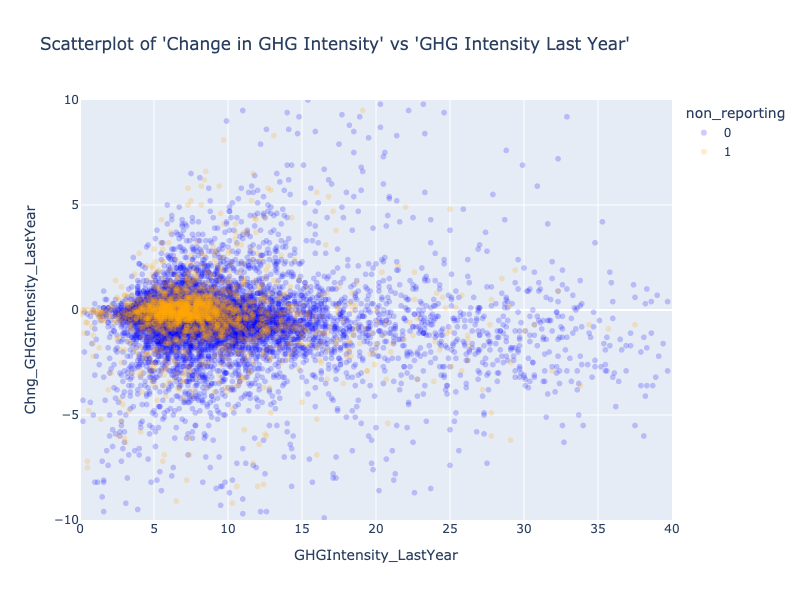

In [632]:
fig = customizable_scatterplot(df,  'GHGIntensity_LastYear', 'Chng_GHGIntensity_LastYear', 'non_reporting' , 
                         x_limits =[0,40], y_limits=[-10,10], title="Scatterplot of 'Change in GHG Intensity' vs 'GHG Intensity Last Year'")

out, reduce_memory = show_fig(fig, reduce_memory)

if reduce_memory:
    with open(os.path.join(fig_dir,'scatterplot_of_GHG_last_year_by_GHG_trend.png'), "wb") as f:
        f.write(out)
    out = Image(out)
out